# <center><h1>Recurrent Neural Networks (RNN) for Time Series Prediction</h1></center>

<center><img src="../Images/SampleRNN.png" alt="RNN Architecture" /></center>

## Overview
RNNs are specialized neural networks designed for sequential data processing, making them ideal for time series analysis. They process data sequentially, maintaining an internal memory of previous inputs.

### Key Characteristics
- Takes sequences as input and produces sequential outputs
- Maintains internal state (memory) between predictions
- Well-suited for variable-length sequences
- Can capture temporal dependencies

### Process Flow
1. Input sequence is fed one element at a time
2. RNN cell processes each element and updates its hidden state
3. Hidden state captures information from previous elements
4. Predictions are made using the current hidden state
5. Process continues until the entire sequence is processed

## Helpful Links
- [Working with RNNs](https://www.tensorflow.org/guide/keras/working_with_rnns)

## Implementation Approaches
We will explore three implementations with increasing complexity:

1. **Basic RNN Model**
   - Single RNN layer
   - Simple dense output layer
   - Basic configuration
   
2. **Complex RNN Model**
   - Multiple RNN layers
   - Dropout for regularization
   - Additional dense layers
   
3. **Testing Multiple Models**
   - Functions to build and train models
   - Functions to evaluate models
   - Compare performance of different models
   - Visualize results

## Implementation Steps
1. **Data Evaluation**
   - Analyze time series characteristics
   - Check for missing values and outliers
   
2. **Dataset Definition**
   - Create input/output sequences
   - Split into training and testing sets
   - Scale/normalize the data

3. **Model Architecture**
   - Define RNN layers
   - Add dense layers
   - Configure output layer

4. **Model Training**
   - Compile with appropriate loss function
   - Train with selected optimizer
   - Monitor validation metrics

5. **Model Evaluation**
   - Calculate prediction accuracy
   - Compare performance across models
   - Analyze error metrics
   - Visualize results

---

In this notebook, we'll build three implementations of RNN models to predict daily temperatures in Delhi, India, using data from [Kaggle](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data). We'll focus on the mean temperature feature and compare the performance of each approach.

## 1. Data Evaluation

### Dataset Overview
We're working with daily temperature data from Delhi, India, split into two CSV files:
- Training data: Historical temperature records (2013-2016)
- Testing data: More recent temperature records (2017)

### Implementation Notes
For this example, we'll focus on the mean temperature feature to demonstrate RNN capabilities. The same principles can be applied to multivariate time series prediction using additional features.

---

First, we use the pandas library to load the data from the CSV files into a dataframe. Describe is a pandas method that provides a summary of the dataframe.


In [45]:
import pandas as pd # for data manipulation
from pathlib import Path # for file path management

training_file = Path('../Data/delhi_climate/DailyDelhiClimateTrain.csv')#../ goes up one directory
testing_file = Path('../Data/delhi_climate/DailyDelhiClimateTest.csv')

training_data_df = pd.read_csv(training_file)
testing_data_df = pd.read_csv(testing_file)

# Print the first 5 rows of the training and testing data
print(training_data_df.head(5))
print(testing_data_df.head(5))

# Print extra inforomation about training data
print(training_data_df.describe())

         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000
         date   meantemp   humidity  wind_speed  meanpressure
0  2017-01-01  15.913043  85.869565    2.743478     59.000000
1  2017-01-02  18.500000  77.222222    2.894444   1018.277778
2  2017-01-03  17.111111  81.888889    4.016667   1018.333333
3  2017-01-04  18.700000  70.050000    4.545000   1015.700000
4  2017-01-05  18.388889  74.944444    3.300000   1014.333333
          meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.495521    60.771702     6.802209   1011.104548
std       7.348103    16.769652     4.561602    180.231668
min       6.000000  

We can see that the data is from 2013 to 2017. Training and testing data have all the same features. Also, our time based variable is date but it is stored as a string. We need to convert it to datetime. This should help us with plotting the data.

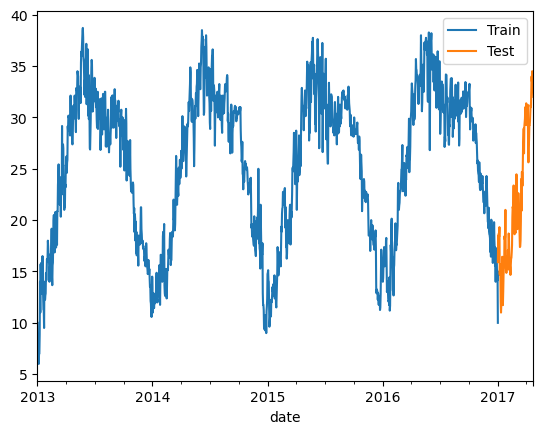

In [46]:
import matplotlib.pyplot as plt

#convert the date column to datetime
training_data_df['date'] = pd.to_datetime(training_data_df['date'])
testing_data_df['date'] = pd.to_datetime(testing_data_df['date'])

# Set the date column as the index
training_data_df.set_index('date', inplace=True)
testing_data_df.set_index('date', inplace=True)

#plot the data over time
training_data_df.meantemp.plot()
testing_data_df.meantemp.plot()
plt.legend (["Train", "Test"])


## 2. Define a dataset

We need our data in a format that can be used by an RNN. This includes two transformations :
1. Scaling the data
2. Adding windowing data

### 2.1. Scaling the data

We need to scale our data to be between 0 and 1. This will help the model converge during training. However, the scaler requires a 2D array as input and out data is in a pandas dataframe. Pay attention to how the data looks before and after this step. I have included a printout of the first 5 rows of the data. Note that the scaled data is not only between 0 and 1, but is now a numpy array with two dimensions. You can think of the first dimension, represented by the outermost brackets in the printed example, as the number of samples. The second dimension, represented by the innermost brackets, is the number of features, in this case just one.

In [47]:
from sklearn.preprocessing import MinMaxScaler # for scaling the data

scaler = MinMaxScaler(
    feature_range = (0, 1) # scale the data to be between 0 and 1
    ).fit(training_data_df.meantemp.values.reshape(-1, 1)) # fit aligns the scaler to the training data, reshape(-1, 1) makes the data a 2D array

# transform the training and testing data
print ("Data before any changes:")
print (training_data_df.meantemp.head(5))

train_data_np = training_data_df.meantemp.values
test_data_np = testing_data_df.meantemp.values

print ("Data after conversion to numpy arrays:")
print (train_data_np[:5])

train_data_np = train_data_np.reshape(-1, 1)
test_data_np = test_data_np.reshape(-1, 1)

print ("Data after reshaping:")
print (train_data_np[:5])

train_scaled = scaler.transform(train_data_np)
test_scaled = scaler.transform(test_data_np)

print ("Data after scaling:")
print (train_scaled[:5])

print ("train_scaled.shape :", train_scaled.shape)
print ("test_scaled.shape :", test_scaled.shape)

Data before any changes:
date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
Name: meantemp, dtype: float64
Data after conversion to numpy arrays:
[10.          7.4         7.16666667  8.66666667  6.        ]
Data after reshaping:
[[10.        ]
 [ 7.4       ]
 [ 7.16666667]
 [ 8.66666667]
 [ 6.        ]]
Data after scaling:
[[0.12227074]
 [0.04279476]
 [0.0356623 ]
 [0.08151383]
 [0.        ]]
train_scaled.shape : (1462, 1)
test_scaled.shape : (114, 1)


### 2.2. Adding windowing data

Windowing is a technique used to create a dataset of input/output pairs.

We will create a window of 30 days and use it to predict the next day's temperature.

An RNN expects each example to be a sequence of data. So, we need to turn our single, long sequence into many shorter sequences. The shorter sequences will mostly overlap, except for the first and last value in each sequence. That is why this is sometimes called a "sliding window". 

To accomplish this I am writing a function. It is helpful to write a function because it can be applied to the testing data as well.

If you keep following the format of the data, you will notice in the printout there is another large change to the data format. Printing the first 5 elements alone cannot fit in the printout. Notice the shape of the data is now 3-dimensional of size (number of samples, window size, number of features).
 - The number of samples will be the original number of samples less the window size, as every sample needs a full window.
 - The window size is the number of days we are using to predict the next day's temperature.
 - The number of features is the number of features in the data, in this case just one.


In [48]:
import numpy as np # for array manipulation

def create_sequences(data: np.ndarray, window_size: int):
    """this function creates trailing sequences of length window_size from the data, producing an X and Y pair of sequences for each sample"""
    X = []
    Y = []

    for i in range(window_size, data.shape[0] - 1): # start range with the window size so every sequence has a full window, then iterate through the data stopping before the latest value, the latest value will be the label for the latest sequence
        X.append(data[i-window_size:i]) # append the last window_size elements of the data to the X list
        Y.append(data[i+1]) # append the next value in the original sequence to Y, making it the value we want to predict

    return np.array(X), np.array(Y)

WINDOW_SIZE = 30 # first config variable

# create the windowed data
print ("Data before windowing:")
print (train_scaled[:5])

X_train_windowed, Y_train_windowed = create_sequences(train_scaled, WINDOW_SIZE)
X_test_windowed, Y_test_windowed = create_sequences(test_scaled, WINDOW_SIZE)

print ("Data after windowing:")
print (X_train_windowed[:5])

print ("train_windowed.shape :", X_train_windowed.shape)


Data before windowing:
[[0.12227074]
 [0.04279476]
 [0.0356623 ]
 [0.08151383]
 [0.        ]]
Data after windowing:
[[[0.12227074]
  [0.04279476]
  [0.0356623 ]
  [0.08151383]
  [0.        ]
  [0.03056769]
  [0.03056769]
  [0.08733624]
  [0.24454148]
  [0.15283843]
  [0.29694323]
  [0.24454148]
  [0.30058224]
  [0.20887918]
  [0.26637555]
  [0.23944687]
  [0.3209607 ]
  [0.23944687]
  [0.19868996]
  [0.16157205]
  [0.15895197]
  [0.1069869 ]
  [0.24454148]
  [0.23944687]
  [0.19104803]
  [0.20378457]
  [0.20960699]
  [0.27001456]
  [0.24836245]
  [0.26637555]]

 [[0.04279476]
  [0.0356623 ]
  [0.08151383]
  [0.        ]
  [0.03056769]
  [0.03056769]
  [0.08733624]
  [0.24454148]
  [0.15283843]
  [0.29694323]
  [0.24454148]
  [0.30058224]
  [0.20887918]
  [0.26637555]
  [0.23944687]
  [0.3209607 ]
  [0.23944687]
  [0.19868996]
  [0.16157205]
  [0.15895197]
  [0.1069869 ]
  [0.24454148]
  [0.23944687]
  [0.19104803]
  [0.20378457]
  [0.20960699]
  [0.27001456]
  [0.24836245]
  [0.2663755

## 3. Model Architecture

### Understanding RNN Models in Keras

Keras provides several pre-implemented RNN architectures to handle sequential data:
- **SimpleRNN**: Basic RNN implementation
- **LSTM** (Long Short-Term Memory): Advanced RNN with better memory handling
- **GRU** (Gated Recurrent Unit): Simplified version of LSTM

For our initial implementation, we'll use `SimpleRNN`. For documentation, see [TensorFlow SimpleRNN API](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN).

### Input Shape Requirements

RNN models expect input data in a specific format:
- Shape: `(samples, timesteps, features)`
  - `samples`: Number of sequences
  - `timesteps`: Length of each sequence (our `WINDOW_SIZE`)
  - `features`: Number of variables per timestep

For our temperature prediction:
- `timesteps = WINDOW_SIZE` (30 days)
- `features = 1` (mean temperature)

### Model Configuration

#### Key Parameters
1. **units**: Number of neurons in the RNN layer
   - Determines the model's capacity to learn patterns
   - For single-value prediction, final dense layer will have 1 unit

2. **input_shape**: Tuple of `(timesteps, features)`
   - Must match our preprocessed data dimensions

#### Optional Parameters
- `activation`: Activation function (default: 'tanh')
- `return_sequences`: Whether to return full sequence or final output, if the next layer is an RNN layer, it should be True, otherwise it should be False
- `dropout`: Regularization to prevent overfitting

### Implementation Note
We'll start with a basic configuration using mostly default parameters to establish a baseline. Later implementations will explore more sophisticated architectures and hyperparameter tuning.

---

The following code implements the simplest RNN model possible for our data. We supply the input shape and 16 as the number of units. The number of units is the number of neurons in the RNN layer. The input shape is the shape of the data we are feeding into the model. There are 3 models in this code. The first model is a simple RNN model with return_sequences=True. The second model is a simple RNN model with return_sequences=False. The third model is a simple RNN model with return_sequences=False and a dense layer. This is to show the difference between the output of the RNN layer and the output of the model. At the end of the code, we define model as model3 and delete the other two models to free up memory.


In [49]:
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.models import Sequential

HIDDEN_SIZE = 16

# First model: SimpleRNN only
print("Model 1: SimpleRNN only (with return_sequences=True)")
model1 = Sequential()
rnn = SimpleRNN(units=HIDDEN_SIZE, input_shape=(WINDOW_SIZE, 1), return_sequences=True)
model1.add(rnn)
model1.summary()

sample_input = X_train_windowed[0].reshape(1, WINDOW_SIZE, 1)
sample_output = model1.predict(sample_input)
print(f"Input shape: {sample_input.shape}")  # Should be (1, WINDOW_SIZE, 1)
print(f"Output shape: {sample_output.shape}")  # Will be (1, WINDOW_SIZE, HIDDEN_SIZE)
print("\n" + "="*50 + "\n")

# Second model: SimpleRNN without return_sequences
print("Model 2: SimpleRNN only (without return_sequences)")
model2 = Sequential()
rnn = SimpleRNN(units=HIDDEN_SIZE, input_shape=(WINDOW_SIZE, 1), return_sequences=False)
model2.add(rnn)
model2.summary()

sample_output = model2.predict(sample_input)
print(f"Input shape: {sample_input.shape}")  # Should be (1, WINDOW_SIZE, 1)
print(f"Output shape: {sample_output.shape}")  # Will be (1, HIDDEN_SIZE)
print("\n" + "="*50 + "\n")

# Third model: SimpleRNN + Dense
print("Model 3: SimpleRNN + Dense (complete model)")
model3 = Sequential()
rnn = SimpleRNN(units=HIDDEN_SIZE, input_shape=(WINDOW_SIZE, 1), return_sequences=False)
model3.add(rnn)
model3.add(Dense(units=1))
model3.summary()

sample_output = model3.predict(sample_input)
print(f"Input shape: {sample_input.shape}")   # Should be (1, WINDOW_SIZE, 1)
print(f"Output shape: {sample_output.shape}")  # Will be (1, 1)

model = model3
del model1
del model2


Model 1: SimpleRNN only (with return_sequences=True)
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_138 (SimpleRNN)  (None, 30, 16)            288       
                                                                 
Total params: 288
Trainable params: 288
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 183ms/step
Input shape: (1, 30, 1)
Output shape: (1, 30, 16)


Model 2: SimpleRNN only (without return_sequences)
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_139 (SimpleRNN)  (None, 16)                288       
                                                                 
Total params: 288
Trainable params: 288
Non-trainable params: 0
_______________________

## 4. Model Training

First, we compile the model with an optimizer and loss. Then use the fit function to train the model for our desired number of epochs.

In [50]:
OPTIMIZER = 'adam'
LOSS = 'mean_squared_error'
EPOCHS = 100
BATCH_SIZE = 30

model.compile(OPTIMIZER, LOSS)
model.fit(X_train_windowed, Y_train_windowed, epochs = EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/100
48/48 [==============================] - 1s 4ms/step - loss: 0.0610
Epoch 2/100
48/48 [==============================] - 0s 4ms/step - loss: 0.0068
Epoch 3/100
48/48 [==============================] - 0s 4ms/step - loss: 0.0059
Epoch 4/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 5/100
48/48 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 6/100
48/48 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 7/100
48/48 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 8/100
48/48 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 9/100
48/48 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 10/100
48/48 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 11/100
48/48 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 12/100
48/48 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 13/100
48/48 [=================

## 5. Model Evaluation

Now that the model is trained we can evaluate it's performance on the test data. 

3/3 [==============================] - 0s 4ms/step


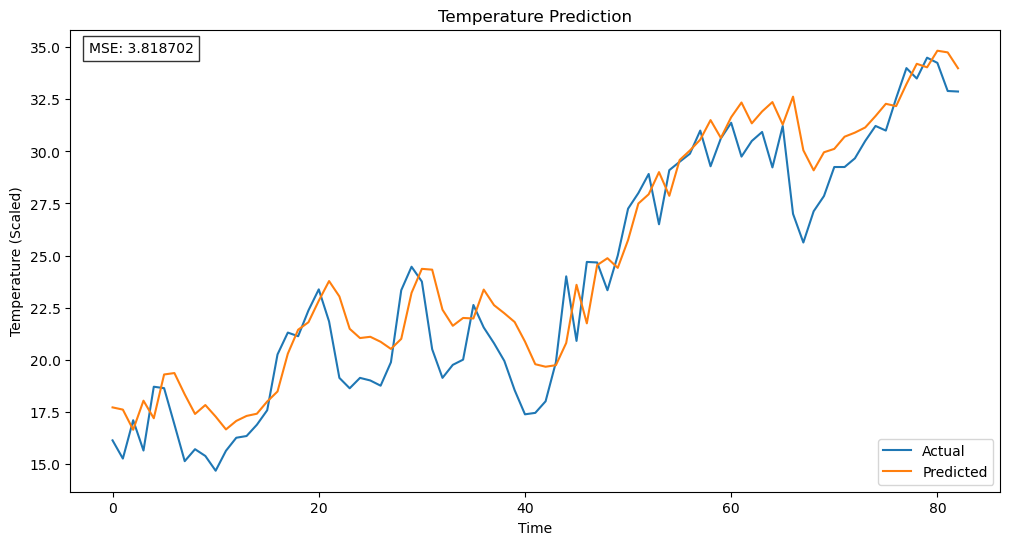

In [51]:
from sklearn.metrics import mean_squared_error

predictions = model.predict(X_test_windowed)
predictions = scaler.inverse_transform(predictions)
labels = testing_data_df.meantemp.values[WINDOW_SIZE:-1]
mse = mean_squared_error(labels, predictions)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(labels, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature (Scaled)')

# Add MSE text to the plot
plt.text(0.02, 0.95, f'MSE: {mse:.6f}', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.legend()

At this point, we have a trained RNN with reasonable performance. We can stop here and use this model for prediction. However, we can also try to improve the model by modifying the architecture.

# Implementation Two: Complex RNN Model

We can leverage the dataset from the previous implementation. However, we want to change the model architecture to see if we can improve the performance. The simplest way to do this is to add more layers to the model. We can add more RNN layers and more dense layers. We can also change the number of units in the model. Remember that between RNN layers, we need to set return_sequences to True if we want to continue the sequence, otherwise we should set it to False.


In [52]:
HIDDEN_SIZE = 32

complex_model = Sequential()
complex_model.add(SimpleRNN(units=HIDDEN_SIZE, input_shape=(WINDOW_SIZE, 1), return_sequences=True))
complex_model.add(SimpleRNN(units=HIDDEN_SIZE, return_sequences=True))
complex_model.add(SimpleRNN(units=HIDDEN_SIZE, return_sequences=False))
complex_model.add(Dense(units=16))
complex_model.add(Dense(units=1))

complex_model.summary()

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_141 (SimpleRNN)  (None, 30, 32)            1088      
                                                                 
 simple_rnn_142 (SimpleRNN)  (None, 30, 32)            2080      
                                                                 
 simple_rnn_143 (SimpleRNN)  (None, 32)                2080      
                                                                 
 dense_176 (Dense)           (None, 16)                528       
                                                                 
 dense_177 (Dense)           (None, 1)                 17        
                                                                 
Total params: 5,793
Trainable params: 5,793
Non-trainable params: 0
_________________________________________________________________


Now we can compile and fit the more complex model.

In [53]:
OPTIMIZER = 'adam'
LOSS = 'mean_squared_error'
EPOCHS = 100
BATCH_SIZE = 30

complex_model.compile(OPTIMIZER, LOSS)
complex_model.fit(X_train_windowed, Y_train_windowed, epochs = EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/100
48/48 [==============================] - 3s 14ms/step - loss: 0.0510
Epoch 2/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0086
Epoch 3/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0066
Epoch 4/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0058
Epoch 5/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0055
Epoch 6/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0053
Epoch 7/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0064
Epoch 8/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0050
Epoch 9/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0044
Epoch 10/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0044
Epoch 11/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0050
Epoch 12/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0053
Epoch 13/100
48/48 [=====

Now that the model is trained we can evaluate it's performance on the test data.

3/3 [==============================] - 0s 5ms/step


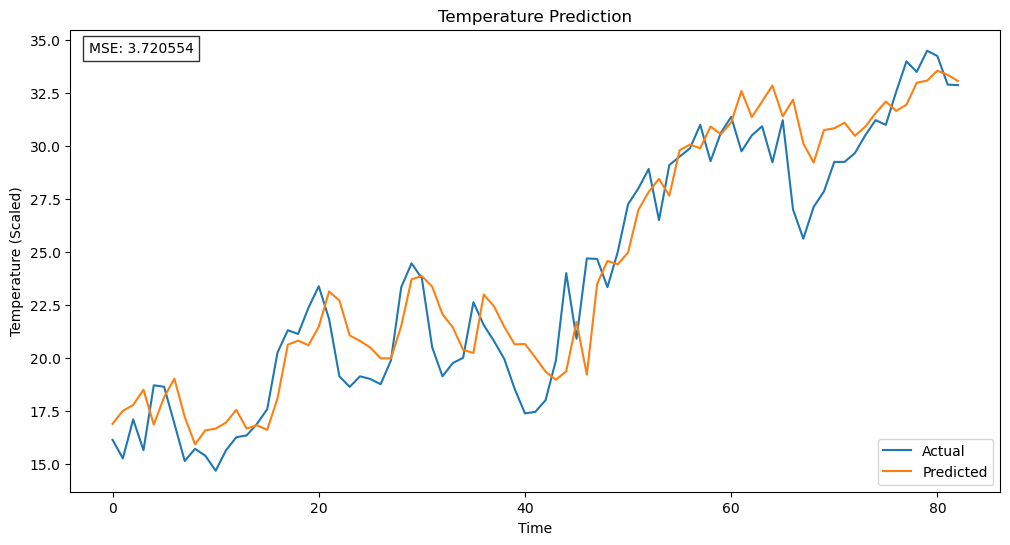

In [54]:
predictions = complex_model.predict(X_test_windowed)
predictions = scaler.inverse_transform(predictions)
labels = testing_data_df.meantemp.values[WINDOW_SIZE:-1]
mse = mean_squared_error(labels, predictions)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(labels, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature (Scaled)')

# Add MSE text to the plot
plt.text(0.02, 0.95, f'MSE: {mse:.6f}', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.legend()

After running this notebook multiple times, sometimes the complex model performs better than the simple model and sometimes it does not. This is a good example of how the model architecture can have a large impact on the performance of the model. Now, in the third implementation, we will write functions so that we can easily try different model architectures and see which one performs best. The final step is to run multiple trials of each model to formulate average performance metrics.

## Implementation Three: Testing Multiple Models
First, we will write a function to build a complex RNN model. This function will take the hidden size for the RNN layers, the number of RNN layers, and the number of dense layers as input. The function will return the model. The dense layers are supplied as a list of integers. The last dense layer will always have 1 unit. The function needs to return sequences only if the next layer is an RNN layer.

In [55]:
def build_complex_rnn(hidden_size: int, num_rnn_layers: int, dense_layers: list[int]):
    model = Sequential()
    for i in range(num_rnn_layers):
        return_sequences = True if i < num_rnn_layers - 1 else False
        model.add(SimpleRNN(units=hidden_size, return_sequences=return_sequences))
    for dense_layer_size in dense_layers:
        model.add(Dense(dense_layer_size))
    model.add(Dense(1))
    return model

Next, we will write a function to compile and fit the model.

In [56]:
def train_model(model, X_train, Y_train, epochs: int, batch_size: int, optimizer: str, loss: str):
    model.compile(optimizer = optimizer, loss = loss)
    model.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size, verbose=0)

Finally, we write a function to evaluate the model.

In [57]:
def evaluate_model(model, X_test, Y_test):

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    labels = Y_test
    mse = mean_squared_error(labels, predictions)

    return mse, predictions

Now with these three functions, we can test a new model architecture by simply changing the parameters.

In [58]:
HIDDEN_SIZE = 64
DENSE_LAYERS = [64, 32, 16]
NUM_RNN_LAYERS = 2
EPOCHS = 10
BATCH_SIZE = 30
OPTIMIZER = 'adam'
LOSS = 'mean_squared_error'

model = build_complex_rnn(hidden_size=HIDDEN_SIZE, num_rnn_layers=NUM_RNN_LAYERS, dense_layers=DENSE_LAYERS)
train_model(model, X_train_windowed, Y_train_windowed, epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=OPTIMIZER, loss=LOSS)
mse, predictions = evaluate_model(model, X_test_windowed, testing_data_df.meantemp.values[WINDOW_SIZE:-1])
print(f"MSE: {mse:.6f}")

3/3 [==============================] - 1s 5ms/step
MSE: 5.165591


Finally, we can test multiple models by defining a dictionary of model configurations and iterating through the dictionary.

In [59]:
HIDDEN_SIZE = 64
DENSE_LAYERS = [64, 32, 16]
NUM_RNN_LAYERS = 2

MODEL_CONFIGS = {
    "2RNN_3DENSE_64HIDDEN": {
        "HIDDEN_SIZE": 64,
        "DENSE_LAYERS": [64, 32, 16],
        "NUM_RNN_LAYERS": 2,
        "EPOCHS": 10,
        "BATCH_SIZE": 30,
        "OPTIMIZER": 'adam',
        "LOSS": 'mean_squared_error'
    },
    "3RNN_2DENSE_32HIDDEN": {
        "HIDDEN_SIZE": 32,
        "DENSE_LAYERS": [32, 16],
        "NUM_RNN_LAYERS": 3,
        "EPOCHS": 10,
        "BATCH_SIZE": 30,
        "OPTIMIZER": 'adam',
        "LOSS": 'mean_squared_error'
    },
    "2RNN_2DENSE_64HIDDEN": {
        "HIDDEN_SIZE": 64,
        "DENSE_LAYERS": [64, 32],
        "NUM_RNN_LAYERS": 2,
        "EPOCHS": 10,
        "BATCH_SIZE": 30,
        "OPTIMIZER": 'adam',
        "LOSS": 'mean_squared_error'
    },
    "2RNN_2DENSE_32HIDDEN": {
        "HIDDEN_SIZE": 32,
        "DENSE_LAYERS": [32, 16],
        "NUM_RNN_LAYERS": 2,
        "EPOCHS": 10,
        "BATCH_SIZE": 30,
        "OPTIMIZER": 'adam',
        "LOSS": 'mean_squared_error'
    }
}


for model_name, config in MODEL_CONFIGS.items():
    print(f"Training {model_name}...")
    model = build_complex_rnn(hidden_size=config["HIDDEN_SIZE"], num_rnn_layers=config["NUM_RNN_LAYERS"], dense_layers=config["DENSE_LAYERS"])
    train_model(model, X_train_windowed, Y_train_windowed, epochs=config["EPOCHS"], batch_size=config["BATCH_SIZE"], optimizer=config["OPTIMIZER"], loss=config["LOSS"])
    mse, predictions = evaluate_model(model, X_test_windowed, testing_data_df.meantemp.values[WINDOW_SIZE:-1])
    print(f"MSE: {mse:.6f}")
    MODEL_CONFIGS[model_name]["predictions"] = predictions




Training 2RNN_3DENSE_64HIDDEN...
3/3 [==============================] - 0s 10ms/step
MSE: 4.531363
Training 3RNN_2DENSE_32HIDDEN...
3/3 [==============================] - 0s 7ms/step
MSE: 5.313624
Training 2RNN_2DENSE_64HIDDEN...
3/3 [==============================] - 0s 4ms/step
MSE: 3.527600
Training 2RNN_2DENSE_32HIDDEN...
3/3 [==============================] - 0s 5ms/step
MSE: 4.318210


Notice that the model_configs dictionary has a predictions key that we can use to plot the predictions of all the models. This enables us to compare the performance of all the models.

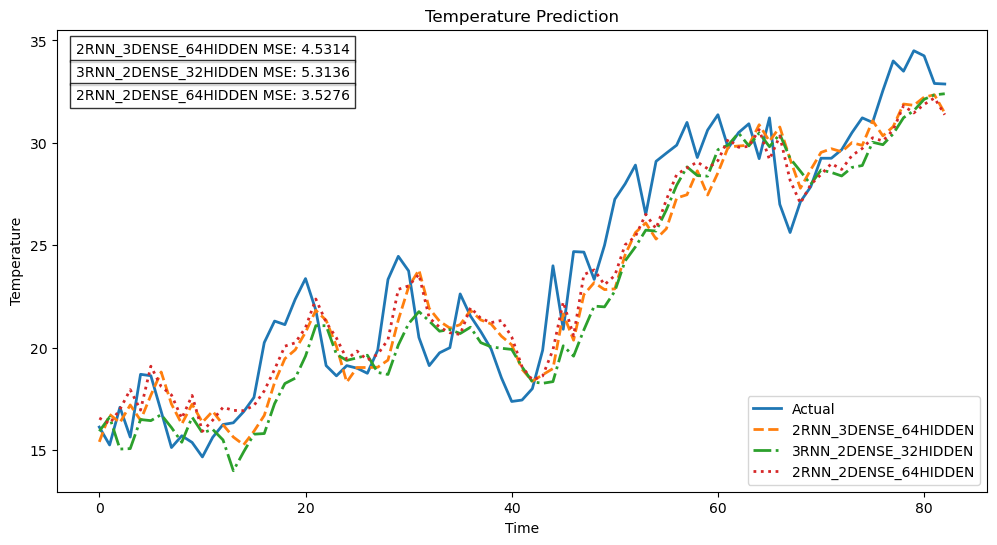

In [60]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(labels, label='Actual', linewidth=2)  # Keep actual line solid
mse_text = []

# Different dash patterns for each prediction line
dash_styles = ['--', '-.', ':']  # Different dash patterns
for (model_name, config), dash in zip(MODEL_CONFIGS.items(), dash_styles):
    plt.plot(config["predictions"], 
             label=model_name, 
             linestyle=dash,
             linewidth=2)  # Make lines slightly thicker for better visibility
    mse = mean_squared_error(labels, config["predictions"])
    mse_text.append(f'{model_name} MSE: {mse:.4f}')

plt.title('Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature')

# Add MSE text to the plot
for i, text in enumerate(mse_text):
    plt.text(0.02, 0.95 - i*0.05,  
             text,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))

plt.legend()

Finally, you can easily run multiple trials of these models to get average performances of architecture choices.

In [61]:
NUM_TRIALS = 10


for model_name, config in MODEL_CONFIGS.items():
    print(f"Training {model_name}...")
    mse_list = []
    predictions_list = []

    for trial in range(NUM_TRIALS):
        
        model = build_complex_rnn(hidden_size=config["HIDDEN_SIZE"], num_rnn_layers=config["NUM_RNN_LAYERS"], dense_layers=config["DENSE_LAYERS"])
        train_model(model, X_train_windowed, Y_train_windowed, epochs=config["EPOCHS"], batch_size=config["BATCH_SIZE"], optimizer=config["OPTIMIZER"], loss=config["LOSS"])
        mse, predictions = evaluate_model(model, X_test_windowed, testing_data_df.meantemp.values[WINDOW_SIZE:-1])
        print(f"MSE: {mse:.6f}")
        mse_list.append(mse)
        predictions_list.append(predictions)

    MODEL_CONFIGS[model_name]["predictions"] = predictions_list
    MODEL_CONFIGS[model_name]["mse"] = mse_list

Training 2RNN_3DENSE_64HIDDEN...
3/3 [==============================] - 0s 11ms/step
MSE: 4.207873
3/3 [==============================] - 0s 4ms/step
MSE: 4.414673
3/3 [==============================] - 0s 14ms/step
MSE: 3.120652
3/3 [==============================] - 0s 5ms/step
MSE: 4.436814
3/3 [==============================] - 0s 5ms/step
MSE: 5.525521
3/3 [==============================] - 0s 5ms/step
MSE: 3.137408
3/3 [==============================] - 0s 4ms/step
MSE: 4.946038
3/3 [==============================] - 0s 5ms/step
MSE: 4.714113
3/3 [==============================] - 0s 4ms/step
MSE: 5.790678
3/3 [==============================] - 0s 4ms/step
MSE: 4.222023
Training 3RNN_2DENSE_32HIDDEN...
3/3 [==============================] - 0s 6ms/step
MSE: 5.674015
3/3 [==============================] - 1s 6ms/step
MSE: 3.214292
3/3 [==============================] - 0s 5ms/step
MSE: 4.107553
3/3 [==============================] - 0s 6ms/step
MSE: 4.149364
3/3 [=================

The predictions and mse are added as lists to the model_configs dictionary. This allows us to plot the predictions and mse for each model.

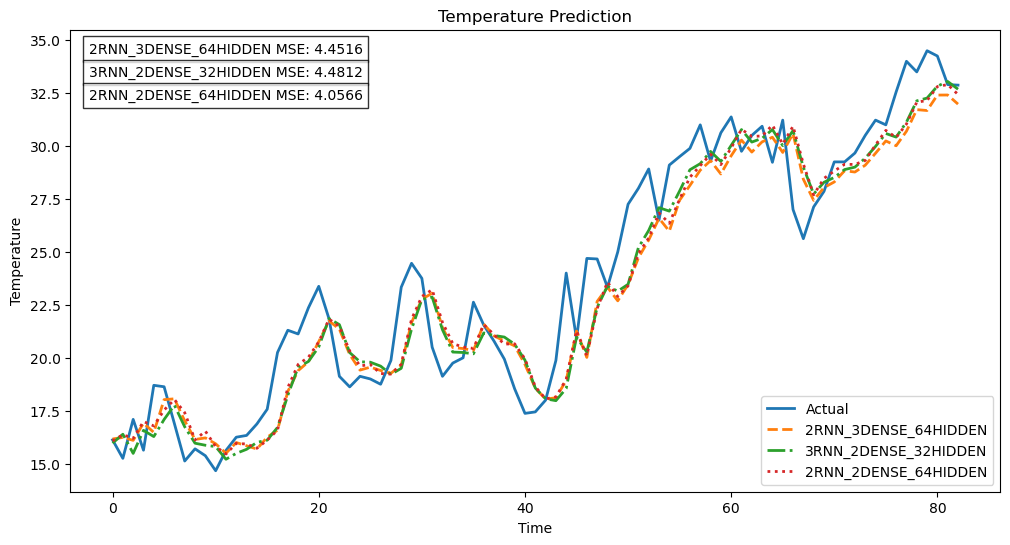

In [62]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(labels, label='Actual', linewidth=2)  # Keep actual line solid
mse_text = []

# Different dash patterns for each prediction line
dash_styles = ['--', '-.', ':']  # Different dash patterns
for (model_name, config), dash in zip(MODEL_CONFIGS.items(), dash_styles):
    plt.plot(np.mean(config["predictions"], axis=0), # average all ten prediction sets
             label=model_name, 
             linestyle=dash,
             linewidth=2)  # Make lines slightly thicker for better visibility
    mse = np.mean(config["mse"])
    mse_text.append(f'{model_name} MSE: {mse:.4f}')

plt.title('Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature')

# Add MSE text to the plot
for i, text in enumerate(mse_text):
    plt.text(0.02, 0.95 - i*0.05,  
             text,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))

plt.legend()

After running multiple trials, we can see that the model architecture with 2 RNN layers and 2 dense layers with 64 units performs the best.
